<a href="https://colab.research.google.com/github/RudyMartin/dsai-2024/blob/main/pt_train_rps_cnn_models_v2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

name: torch_train_rps_cnn_models.py

status: add more evaulation charts

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from google.colab import drive
import numpy as np  # Added for saving losses
import matplotlib.pyplot as plt  # Added for plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. Mount Google Drive to access the dataset
drive.mount('/content/gdrive')

# 2. Verify and list directories
root_dir = '/content/gdrive/My Drive/'
print(os.listdir(root_dir))

rps_dir = os.path.join(root_dir, 'rps')
if os.path.exists(rps_dir):
    print(f"'rps' directory contents: {os.listdir(rps_dir)}")
else:
    raise FileNotFoundError(f"Directory {rps_dir} does not exist.")

train_dir = os.path.join(rps_dir, 'train')
test_dir = os.path.join(rps_dir, 'test')
model_dir = os.path.join(root_dir, 'model')
os.makedirs(model_dir, exist_ok=True)
print(f"rps directory contents: {os.listdir(rps_dir)}")

# 3. Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((160, 120), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Adjust based on your dataset statistics
])

# 4. Just normalization for testing
transform_test = transforms.Compose([
    transforms.Resize((160, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Adjust based on your dataset statistics
])

# 5. Paths to training and testing datasets
train_path = os.path.join(rps_dir, 'train')
test_path = os.path.join(rps_dir, 'test')

if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training directory {train_path} does not exist.")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Testing directory {test_path} does not exist.")

# 6. Load datasets
trainset = ImageFolder(root=train_path, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = ImageFolder(root=test_path, transform=transform_test)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

# 7. Class labels
classes = ('rock', 'paper', 'scissors')

# 8. Define the CNN model
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 20 * 15, 256)  # Adjusted input size for smaller images
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 9. Instantiate two models for comparison
model_1 = ImprovedNet()
model_2 = ImprovedNet()

# 10. Define loss function and optimizers for both models
criterion = nn.CrossEntropyLoss()

# 10. Optimizer and learning rate scheduler for model_1
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.1)

# 10. Optimizer and learning rate scheduler for model_2
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)
scheduler_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_2, T_max=50)

# Initialize lists to store losses for plotting
losses_1 = []
losses_2 = []

# 11. Training loop for model_1
for epoch in range(5):  # Increase number of epochs to 50 for a real training scenario, using 5 for demo
    running_loss = 0.0
    model_1.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_1.zero_grad()  # Zero the parameter gradients
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagate the loss
        optimizer_1.step()  # Update the model parameters
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Model 1, Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    scheduler_1.step()  # Update the learning rate
    losses_1.append(running_loss / len(trainloader))

print('Finished Training Model 1')

# 12. Save the trained model_1
model_1_path = os.path.join(model_dir, 'model_1.pth')
torch.save(model_1.state_dict(), model_1_path)
print(f"Model 1 saved to {model_1_path}")

# 11. Training loop for model_2
for epoch in range(5):  # Increase number of epochs to 50 for a real training scenario, using 5 for demo
    running_loss = 0.0
    model_2.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_2.zero_grad()  # Zero the parameter gradients
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagate the loss
        optimizer_2.step()  # Update the model parameters
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Model 2, Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    scheduler_2.step()  # Update the learning rate
    losses_2.append(running_loss / len(trainloader))

print('Finished Training Model 2')

# 12. Save the trained model_2
model_2_path = os.path.join(model_dir, 'model_2.pth')
torch.save(model_2.state_dict(), model_2_path)
print(f"Model 2 saved to {model_2_path}")

# Save the losses for later use in evaluation script
np.save(os.path.join(model_dir, 'losses_1.npy'), losses_1)
np.save(os.path.join(model_dir, 'losses_2.npy'), losses_2)



Mounted at /content/gdrive
['DSC02677.jpeg', 'Colab Notebooks', 'dscamp_2023', 'dscamp_2022', 'proportions.csv', 'proportions.gsheet', 'activeloop_2023', 'Untitled spreadsheet (1).gsheet', 'Untitled spreadsheet.gsheet', 'YouTube', 'Copy of My Presentation.gslides', 'Introduction .gslides', 'Copy of Introduction .gslides', 'dscamp', 'dscamp_2024_nano', 'ds_camp_2024_trans_hf', 'rps_test', 'rps', 'rps_pics', 'papers']
'rps' directory contents: ['test', 'train', 'models', 'modelsbaseline_1.keras', 'df_metrics_20240610.csv', 'model.h5', 'model.pth', 'model.keras', 'pt_model.pth', 'df_metrics_baseline_1_20240610.csv', 'sequential_acc_graph.png', 'sequential_loss_graph.png']
rps directory contents: ['test', 'train', 'models', 'modelsbaseline_1.keras', 'df_metrics_20240610.csv', 'model.h5', 'model.pth', 'model.keras', 'pt_model.pth', 'df_metrics_baseline_1_20240610.csv', 'sequential_acc_graph.png', 'sequential_loss_graph.png']
Finished Training Model 1
Model 1 saved to /content/gdrive/My Driv

In [14]:
# 13. Testing loop for model_1
correct = 0
total = 0
model_1.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of model_1 on the test images: {100 * correct // total} %')

Accuracy of model_1 on the test images: 44 %


In [13]:
# 13. Testing loop for model_2
correct = 0
total = 0
model_2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of model_2 on the test images: {100 * correct // total} %')

Accuracy of model_2 on the test images: 38 %


In [16]:
# 14. Accuracy for each class for model_1
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_1(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for model_1 class: {classname:5s} is {accuracy:.1f} %')

Accuracy for model_1 class: rock  is 100.0 %
Accuracy for model_1 class: paper is 33.3 %
Accuracy for model_1 class: scissors is 0.0 %


In [15]:
# 14. Accuracy for each class for model_2
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for model_2 class: {classname:5s} is {accuracy:.1f} %')

Accuracy for model_2 class: rock  is 50.0 %
Accuracy for model_2 class: paper is 66.7 %
Accuracy for model_2 class: scissors is 0.0 %


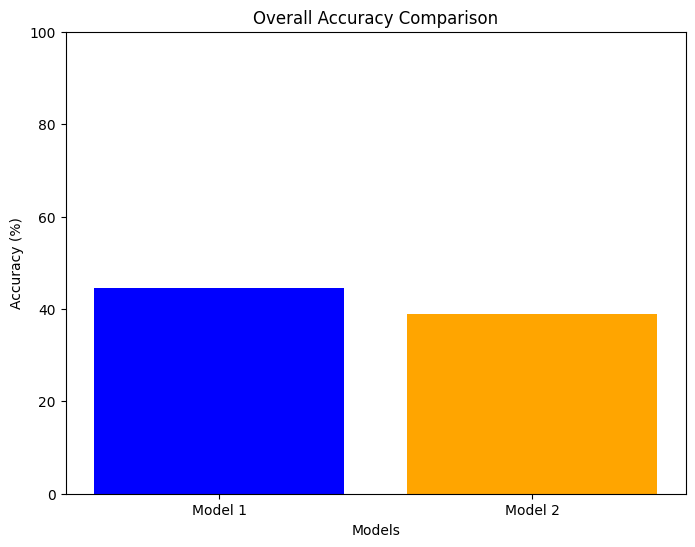

In [11]:
# Evaluate model accuracy
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    accuracy = 100 * correct / total
    class_accuracy = {classname: 100 * float(correct_pred[classname]) / total_pred[classname] for classname in classes}
    return accuracy, class_accuracy

# Get accuracy for both models
accuracy_1, class_accuracy_1 = evaluate_model(model_1, testloader)
accuracy_2, class_accuracy_2 = evaluate_model(model_2, testloader)

# Load the training loss data
losses_1 = np.load(os.path.join(model_dir, 'losses_1.npy'))
losses_2 = np.load(os.path.join(model_dir, 'losses_2.npy'))

# Plot overall accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(['Model 1', 'Model 2'], [accuracy_1, accuracy_2], color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Overall Accuracy Comparison')
plt.ylim(0, 100)
plt.show()



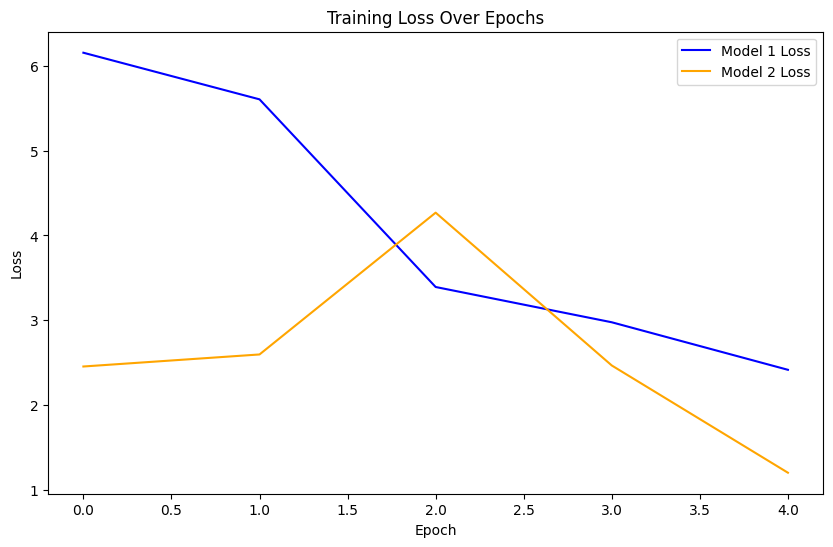

In [9]:
#Plot training loss over epochs for both models
plt.figure(figsize=(10, 6))
plt.plot(losses_1, label='Model 1 Loss', color='blue')
plt.plot(losses_2, label='Model 2 Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [10]:
# Print classification report for both models
def print_classification_report(model, testloader, title):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_preds.extend(predictions.numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=classes, zero_division=0)
    print(title)
    print(report)

print_classification_report(model_1, testloader, 'Classification Report for Model 1')

Classification Report for Model 1
              precision    recall  f1-score   support

        rock       0.40      1.00      0.57         6
       paper       0.67      0.33      0.44         6
    scissors       0.00      0.00      0.00         6

    accuracy                           0.44        18
   macro avg       0.36      0.44      0.34        18
weighted avg       0.36      0.44      0.34        18



In [6]:
print_classification_report(model_2, testloader, 'Classification Report for Model 2')

Classification Report for Model 2
              precision    recall  f1-score   support

        rock       0.43      0.50      0.46         6
       paper       0.36      0.67      0.47         6
    scissors       0.00      0.00      0.00         6

    accuracy                           0.39        18
   macro avg       0.26      0.39      0.31        18
weighted avg       0.26      0.39      0.31        18

